In [1]:
import os
import tkinter as tk
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from tkinter import filedialog as fd

In [22]:
class MZI_exp:
    def __init__(self, exp_name = "", wvl=[], vol=[], fsr=0, ext=[], minmax_short=[]):
        self.exp_name = exp_name
        self.wvl = wvl
        self.vol = vol
        self.fsr = fsr
        self.ext = ext
        self.minmax_short = minmax_short

class MZI:
    def __init__(self, col, row, num_experiments, leng = 0): # see if num_experiments can be moved out later
        self.col = col
        self.row = row
        self.leng = leng
        self.exp = [None] * num_experiments

    def printDetails(self):
            print(f"Device: ({self.col},{self.row}), PCM length: {self.leng} um")

In [ ]:
cols, rows = (3, 12)
arr = [[MZI(j+1,i+1,2) for i in range(rows)] for j in range(cols)]
print(arr[1][2].col)
print(arr[1][2].row)

print(arr[1][11].col)

arr[1][2].col = 4
print(arr[1][2].col)




2
3
2
4


In [30]:
# CREATE AN ARRAY OF BLANK MZIs MATCHING CHIP CONFIGURATION ########################################################## WORKING
def makeMZIarray(cols, rows, num_experiments):
    MZI_arr = []
    for j in range(cols): # 3
        row = []
        for i in range(rows):
            mzi = MZI(j+1,i+1, num_experiments)
            row.append(mzi)
        MZI_arr.append(row)

    print(len(MZI_arr))
    print(len(MZI_arr[0]))


    for j in range(cols): # saveing the PCM length from my devices as a variable
        for i in range(rows):
            # print(f"column: {j} row: {i}")
            if j == 2:
                leng = 15
            else:
                leng = round(15 - i*1.1,1) 
                if (i) == 11:
                    leng = 0
            MZI_arr[j][i].leng = leng

    return(MZI_arr)

MZI_arr1 = makeMZIarray(3,12,2)

3
12


In [31]:
experiments = 2
MZI_arr1 = makeMZIarray(3,12,experiments)

# for j in range(cols):
#     for i in range(rows):
#         MZI_arr1[j][i].printDetails()

col = 3
row = 3

exp_name = "test"
wavelength_array = [1,1,1,1,1]
voltage_array = [1,1,1,1,1]

fsr = 12
ext = [1,2,3]
minmax_short = [1,2,3]

exp_num = 0

mziexp = MZI_exp(exp_name, wavelength_array, voltage_array, fsr, ext, minmax_short)

# print(f"length of exp array should be 2: {len(MZI_arr[col-1][row-1].exp)}")

# print(f'col-1: {col-1}, row-1: {row-1}, exp_num: {exp_num}')
# MZI_arr1[col-1][row-1].printDetails()

MZI_arr1[col-1][row-1].exp[exp_num] = mziexp

print(MZI_arr1[col-1][row-1].exp[exp_num].fsr)
print(MZI_arr1[col-1][row].exp[exp_num].fsr)

print(MZI_arr1[col-1][row].exp[exp_num].fsr is MZI_arr1[col-1][row-1].exp[exp_num].fsr)

3
12
12


AttributeError: 'NoneType' object has no attribute 'fsr'

In [32]:
num_experiments = 2
cols = 3
rows = 12
MZI_arr = makeMZIarray(cols,rows,num_experiments)

for j in range(cols):
    for i in range(rows):
        MZI_arr[j][i].printDetails()


3
12
Device: (1,1), PCM length: 15.0 um
Device: (1,2), PCM length: 13.9 um
Device: (1,3), PCM length: 12.8 um
Device: (1,4), PCM length: 11.7 um
Device: (1,5), PCM length: 10.6 um
Device: (1,6), PCM length: 9.5 um
Device: (1,7), PCM length: 8.4 um
Device: (1,8), PCM length: 7.3 um
Device: (1,9), PCM length: 6.2 um
Device: (1,10), PCM length: 5.1 um
Device: (1,11), PCM length: 4.0 um
Device: (1,12), PCM length: 0 um
Device: (2,1), PCM length: 15.0 um
Device: (2,2), PCM length: 13.9 um
Device: (2,3), PCM length: 12.8 um
Device: (2,4), PCM length: 11.7 um
Device: (2,5), PCM length: 10.6 um
Device: (2,6), PCM length: 9.5 um
Device: (2,7), PCM length: 8.4 um
Device: (2,8), PCM length: 7.3 um
Device: (2,9), PCM length: 6.2 um
Device: (2,10), PCM length: 5.1 um
Device: (2,11), PCM length: 4.0 um
Device: (2,12), PCM length: 0 um
Device: (3,1), PCM length: 15 um
Device: (3,2), PCM length: 15 um
Device: (3,3), PCM length: 15 um
Device: (3,4), PCM length: 15 um
Device: (3,5), PCM length: 15 um
De

In [33]:
print(len(MZI_arr))
print(len(MZI_arr[0]))

3
12


In [ ]:
def addData(MZI_arr, folderpath, exp_num, exp_name):
    plt.rcParams['agg.path.chunksize'] = 10000 #prevents matplot crash if there are too many data points

    # #Popup Menu to select File
    # root = tk.Tk()
    # root.withdraw()  
    # folderpath = fd.askdirectory()
        
    #process all the files in the folder
    for filename in os.listdir(folderpath):
        if not filename.startswith('.') and os.path.isfile(os.path.join(folderpath, filename)):
            filepath = os.path.join(folderpath, filename)
            # print(filepath)
            wavelength = []
            voltage = []

            with open(filepath, 'r', encoding="utf-8", errors="ignore") as file:
                for line in file:
                    data = line.strip().split('\t')
                    wavelength.append(data[0])
                    if len(data) > 1:  # Ensure there are at least two elements
                        voltage.append(data[1])
                    else:
                        print(f"Skipping line due to insufficient data: ")
                        print(line)
            
            #Wavelength x-axis, Voltage y-axis
            wavelength_array = np.array(wavelength, dtype='float64')
            voltage_array = np.array(voltage, dtype='float64')
            
            #find the Maxima of the graph
            distance = 85000
            maxima, _ = signal.find_peaks(voltage_array, distance=distance)
            minima, _ = signal.find_peaks(-voltage_array, distance=distance)


            minmax = np.concatenate((maxima, minima))
            minmax.sort()


            np.diff(maxima) # check what this does
            fsr = 0
            avg_wave=0
            divisions = len(maxima)
            wave = wavelength_array[maxima]

            #Average FSR
            for i in range(1,len(wave)-1):
                avg_wave +=  wave[i] - wave[i-1]
            if(divisions>0):
                fsr = avg_wave/divisions



            minmax_short = []
            mid = len(minmax)//2 #good
            # # PRINT FOR DEBUGGING
            # print(f"mid: {mid}") #good
            # print(f"mid vol: {voltage_array[minmax[mid]]}") #good
            # print(f"mid wvl: {wavelength_array[minmax[mid]]}") #good

            ext = [] # extinction ratio
            num_points = 6 # only do even numbers for now
            if (voltage_array[minmax[mid]] < voltage_array[minmax[mid+1]]):
                minmax_short = minmax[mid-(num_points-1) : mid+num_points+2] 
            else:
                minmax_short = minmax[mid-num_points:mid+num_points+1]

            for i in range(num_points):
                ext.append(1 - (2*voltage_array[minmax_short[2*i+1]]) / (voltage_array[minmax_short[2*i]] + voltage_array[minmax_short[2*i+2]]))
                # #PRINT FOR DEBUGGING
                # print(f"(left {voltage_array[minmax_short[2*i]]} + right {voltage_array[minmax_short[2*i+2]]}) / (2* min {voltage_array[minmax_short[2*i+1]]})")
                # print(f"(left {wavelength_array[minmax_short[2*i]]} + right {wavelength_array[minmax_short[2*i+2]]}) / (2* min {wavelength_array[minmax_short[2*i+1]]})")

            # #PRINT FOR DEBUGGING
            # for i in range(len(ext)):
            #     print(ext[i])

            # SAVING DATA INTO THE MZI ARRAY #####################################################################

            col = int("".join([ele for ele in filename.split()[1] if ele.isdigit()])[0])
            row = int("".join([ele for ele in filename.split()[1] if ele.isdigit()])[1:])

            mziexp = MZI_exp(exp_name, wavelength_array, voltage_array, fsr, ext, minmax_short)

            # if(len(MZI_arr[col-1][row-1].exp) == 0):
            #     while(len(MZI_arr[col-1][row-1].exp < exp_num))
            #     if(len(MZI_arr[col-1][row-1].exp < exp_num)):


            print(f'col-1: {col-1}, row-1: {row-1}, exp_num: {exp_num}')
            MZI_arr[col-1][row-1].printDetails()
            


            MZI_arr[col-1][row-1].exp[exp_num] = mziexp

            print(MZI_arr[col-1][row-1].exp[exp_num].fsr)



def plotData(MZI_arr, col, row, exp_num, save = False):

    voltage_array = MZI_arr[col-1][row-1].exp[exp_num].vol
    wavelength_array = MZI_arr[col-1][row-1].exp[exp_num].wvl
    fsr = MZI_arr[col-1][row-1].exp[exp_num].fsr
    ext = MZI_arr[col-1][row-1].exp[exp_num].ext
    name = MZI_arr[col-1][row-1].exp[exp_num].exp_name

    min_voltage = np.min(voltage_array)
    max_voltage = np.max(voltage_array)

    #find the maxima and minima of the graph
    distance = 85000
    maxima, _ = signal.find_peaks(voltage_array, distance=distance)
    minima, _ = signal.find_peaks(-voltage_array, distance=distance)

    minmax = np.concatenate((maxima, minima))
    minmax.sort()

    #Graph Setup
    plt.figure(figsize=(12, 8))
    plt.title(f"Device ({col},{row}) - {name}")
    plt.xticks(np.arange(wavelength_array[0]-10, wavelength_array[-1]+10, 5.0))
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Voltage (a.u.)")


    plt.plot(wavelength_array,voltage_array)
    plt.figtext(0.5,0.95, f"Average FSR: {fsr:.3f}, Average Extinction Ratio: {(sum(ext) / len(ext)):.3f}", horizontalalignment='center')

    plt.vlines(wavelength_array[maxima],min_voltage,max_voltage,linestyles="dashed",colors="lightblue")
    
    plt.plot(wavelength_array[maxima],voltage_array[maxima],"x")

    for points in maxima:
        plt.annotate(f"{wavelength_array[points]:.5f}", (wavelength_array[points],voltage_array[points]))

    # plt.plot(wavelength_array[minima],voltage_array[minima],"x")

    # plt.plot(wavelength_array[minmax],voltage_array[minmax],"x")


    minmax_short = []
    mid = len(minmax)//2 #good

    num_points = 6 # only do even numbers for now
    if (voltage_array[minmax[mid]] < voltage_array[minmax[mid+1]]):
        minmax_short = minmax[mid-(num_points-1) : mid+num_points+2] 
    else:
        minmax_short = minmax[mid-num_points:mid+num_points+1]
    
    j = 0
    for points in range(len(minmax_short)):
        if points%2 == 1:
            x = wavelength_array[minmax_short[points]]
            y = voltage_array[minmax_short[points]]
            plt.annotate(f"Ext: {ext[j]:.3f}", 
                (x, y), 
                textcoords="offset points", 
                xytext=(0, -10),  # 10 points below the peak
                ha='center', 
                va='top',
                fontsize=8)
            j+=1

    # if (save == True):
    #     plt.savefig(f"{folderpath}/plots/{filename.split('.')[0]}.png", dpi=650, bbox_inches="tight")
    #     plt.close()

    plt.show()


In [37]:

datapath0 = '/Users/kamilakunes/BerkeleyLab/PCM_Project/Data/022124_PCM_short_MZI_Annealed'
exp_num = 0
addData(MZI_arr,datapath0,exp_num,'Before PCM Deposition')

datapath1 = '/Users/kamilakunes/BerkeleyLab/PCM_Project/Data/061225PCMiDep'
exp_num = 1
addData(MZI_arr,datapath1,exp_num,'After PCM Deposition (Crystalline)')


col-1: 2, row-1: 2, exp_num: 0
Device: (3,3), PCM length: 15 um
8.929909374999994
col-1: 0, row-1: 10, exp_num: 0
Device: (1,11), PCM length: 4.0 um
9.00242
col-1: 1, row-1: 3, exp_num: 0
Device: (2,4), PCM length: 11.7 um
8.992019999999997
col-1: 1, row-1: 7, exp_num: 0
Device: (2,8), PCM length: 7.3 um
9.016364999999993
col-1: 1, row-1: 5, exp_num: 0
Device: (2,6), PCM length: 9.5 um
8.999849374999997
col-1: 2, row-1: 0, exp_num: 0
Device: (3,1), PCM length: 15 um
8.944850000000002
col-1: 1, row-1: 6, exp_num: 0
Device: (2,7), PCM length: 8.4 um
8.591373529411772
col-1: 1, row-1: 2, exp_num: 0
Device: (2,3), PCM length: 12.8 um
8.885874999999999
col-1: 2, row-1: 5, exp_num: 0
Device: (3,6), PCM length: 15 um
8.846970000000002
col-1: 1, row-1: 1, exp_num: 0
Device: (2,2), PCM length: 13.9 um
8.955435624999993
col-1: 2, row-1: 6, exp_num: 0
Device: (3,7), PCM length: 15 um
8.941889999999987
col-1: 2, row-1: 3, exp_num: 0
Device: (3,4), PCM length: 15 um
8.932005000000004
col-1: 1, row-

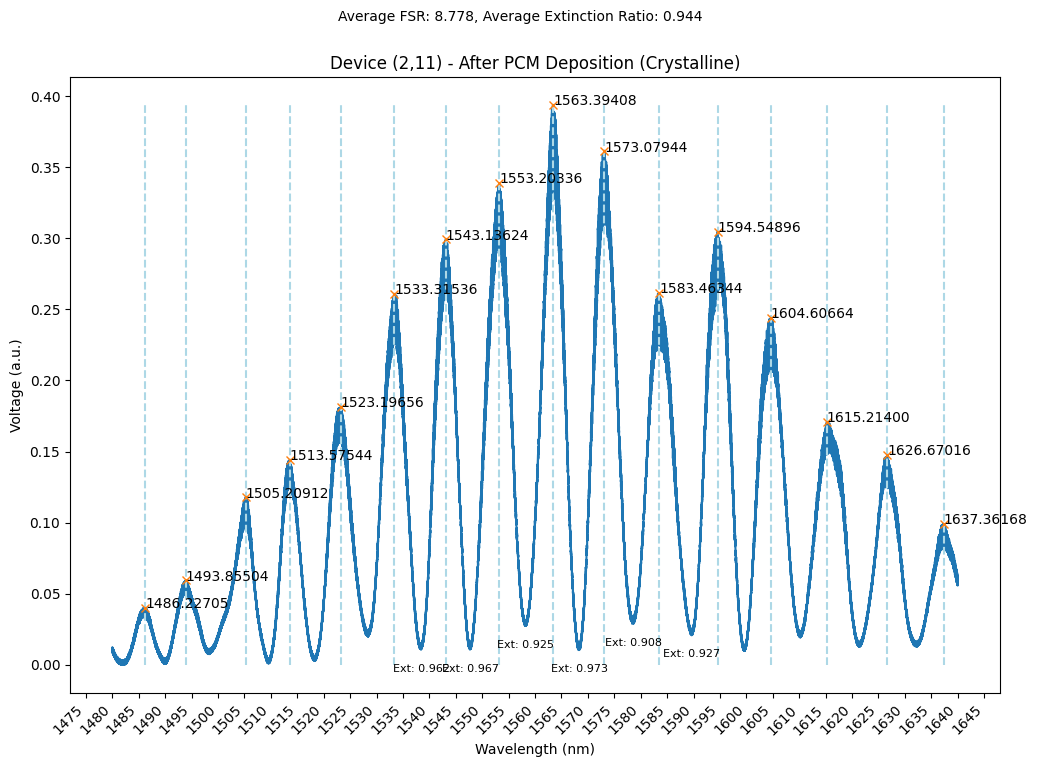

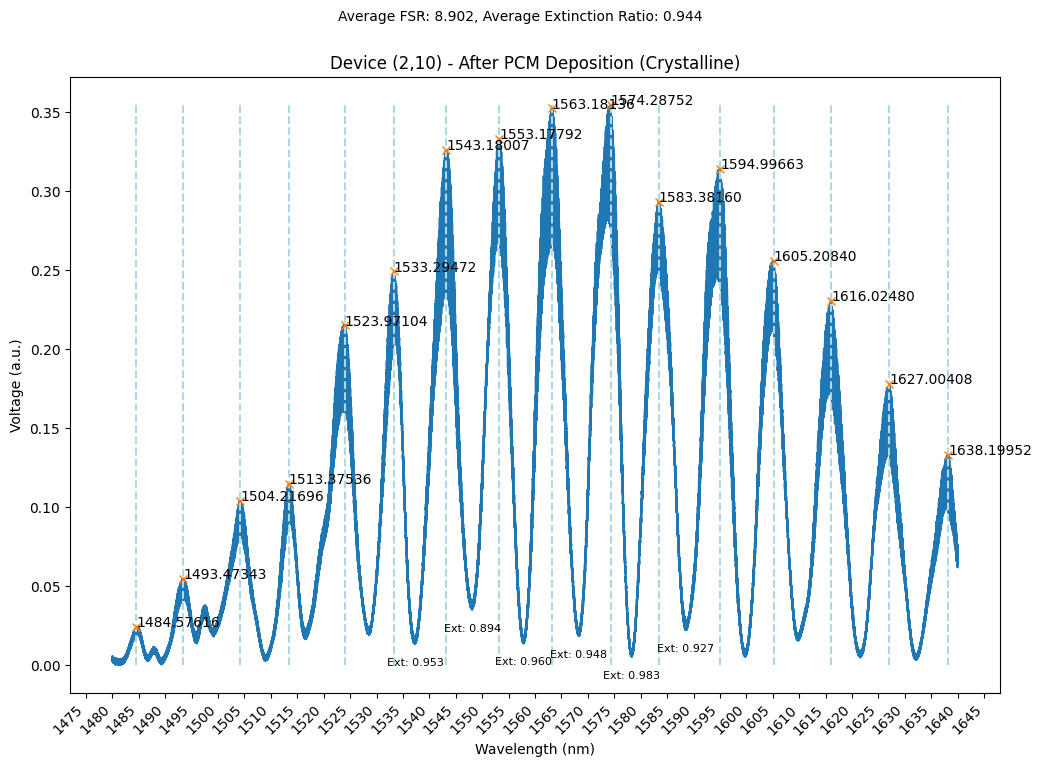

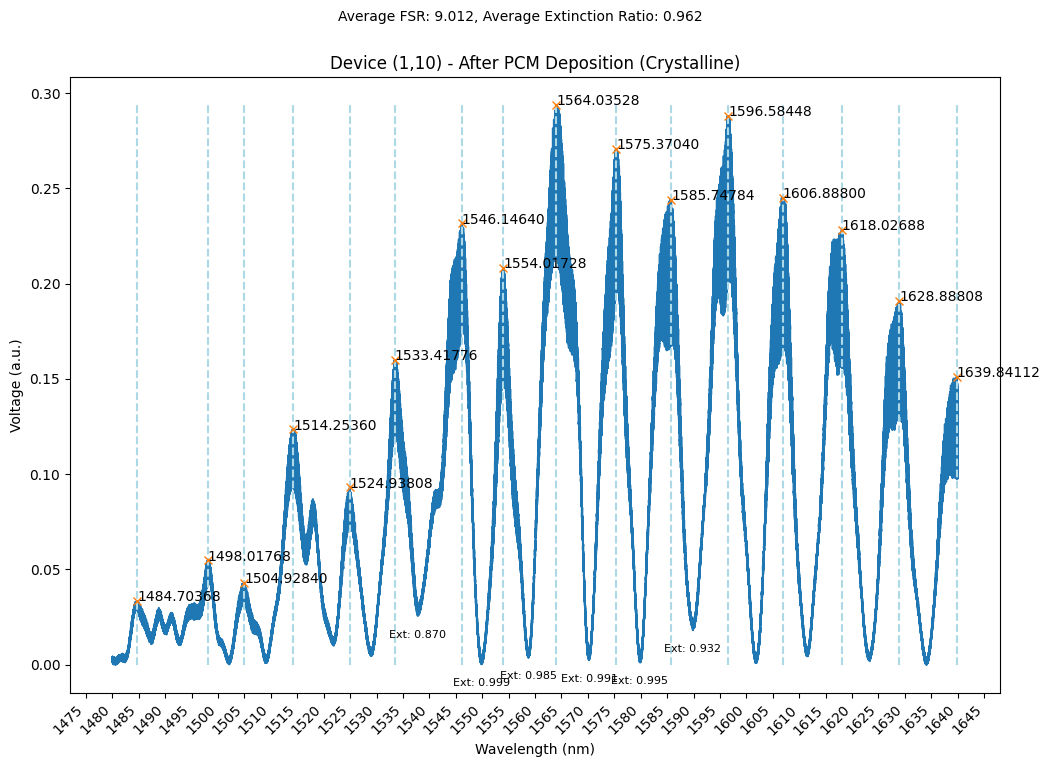

In [40]:
# (MZI_arr, col, row, exp_num, save = False):
plotData(MZI_arr,2,11,1)
plotData(MZI_arr,2,10,1)
plotData(MZI_arr,1,10,1)

In [ ]:
# FSR DOT PLOTS I MADE A WHILE AGO - NOT NEEDED ANYMORE

# #Measurement Before PCM Deposition

# fsr = [8.82, 8.98, 8.53, 8.93, 8.97, 8.42, 8.39, 8.82, 8.96, 8.95, 9.00, 8.87, 8.92, 8.96, 8.89, 8.99, 8.98, 9.00, 8.59, 9.02, 8.83, 8.82, 8.97, 8.95, 8.94, 8.94, 8.93, 8.93, 9.01, 8.85, 8.94, 8.89, 8.95, 8.93, 8.97, 8.91]
# fsr_round = np.round(fsr, decimals=1)
# fsr_avg = sum(fsr) / len(fsr)
# fsr_std_dev = np.std(fsr, ddof=0)

# unique_values, counts = np.unique(fsr_round, return_counts=True)
# colors = plt.cm.viridis(np.linspace(0, 1, len(unique_values)))  # Generate colors

# plt.figure(figsize=(6, 4))

# for i, (val, count) in enumerate(zip(unique_values, counts)):
#     plt.scatter([val] * count, range(1, count + 1), s=100, color=colors[i])

# plt.axvline(x=fsr_avg, color = 'r',linestyle='--', label = f"Average FSR = {fsr_avg:.2f} nm")
# plt.xticks(np.arange(7.6, 9.3, step=0.2))
# plt.yticks([])
# plt.xlabel("FSR (nm)")
# plt.title(f"MZI Average FSR (Std Dev: {fsr_std_dev:.2f})")
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.legend(fontsize=11)

# plt.show()




# # Initial Measurement After PCM Deposition

# fsr_idep = [8.19, 8.12, 8.68, 7.90, 8.89, 8.83, 8.51, 8.81, 8.71, 9.01, 8.83, 8.80, 8.67, 8.72, 8.70, 8.42, 8.34, 8.20, 8.88, 8.80, 8.13, 8.90, 8.78, 8.98, 8.72, 8.66, 8.43, 8.64, 8.40, 8.94, 8.49, 8.43, 7.78, 8.27, 8.26, 8.79]
# fsr_round_idep = np.round(fsr_idep, decimals=1)
# fsr_avg_idep = sum(fsr_idep) / len(fsr_idep)
# fsr_std_dev_idep = np.std(fsr_idep, ddof=0)

# unique_values, counts = np.unique(fsr_round_idep, return_counts=True)
# colors = plt.cm.viridis(np.linspace(0, 1, len(unique_values)))  # Generate colors

# plt.figure(figsize=(6, 4))

# for i, (val, count) in enumerate(zip(unique_values, counts)):
#     plt.scatter([val] * count, range(1, count + 1), s=100, color=colors[i])

# plt.axvline(x=fsr_avg_idep, color = 'r',linestyle='--', label = f"Average FSR = {fsr_avg_idep:.2f} nm")
# plt.xticks(np.arange(7.6, 9.3, step=0.2))
# plt.yticks([])
# plt.xlabel("FSR (nm)")
# plt.title(f"MZI Average FSR (Std Dev: {fsr_std_dev_idep:.2f})")
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.legend(fontsize=11)

# plt.show()